In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader, Subset, SubsetRandomSampler, random_split
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from matplotlib import pyplot as plt
import lmfit
from scipy import interpolate
from scipy import stats

In the above strategy, we have developed several core algorithms. These algorithms range from 
 
  * Training a single model to fit data and find discriminiator
  * Using an analytic fitting for the data
  * Fitting a discriminator separately for passing and failing
  * Fitting the difference between passing and failing


Now that we have established a baseline algorithm. Our goal will be to come up with a few simplified scenarios to test the robustness of the method. We will forgo the single training option, but we will include it in the code. All of this is documented in SplitFitter, we will just use the lmfit option, which captures the bottom 3 options. We can then apply it to a bunch of our cases. 

First, we want to show the performance compared to ideal, with different signal sizes. We will consider a total number of events of 20000 events with a signals ranging from 0.5 percent to 2.5 percent.

Next, we will consider 1 variable with 3 background models
 * flat
 * Linear
 * power law $x^{-4}$

Next, we will consider 1 variable with mass correlation in 3 background models
 * flat
 * Linear
 * power law $x^{-4}$

Then we will consdier 2 variables with 3 background models
 * flat
 * Linear
 * power law $x^{-4}$

The two will be either 1 variable, and one dummy, and then 2 partially correlated

Then we will consdier N variables with 3 background models and random corrleations N => 3 to 20
 * flat
 * Linear
 * power law $x^{-4}$

Finally, we will consider 1 varaible with incorrect signal and background models. 



In [69]:
class DataSet(Dataset):
    def __init__(self, samples, labels):
        super(DataSet, self).__init__()
        self.labels  = labels
        self.samples = samples
        if len(samples) != len(labels):
            raise ValueError(
                f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        y = self.labels[index]
        x = self.samples[index]
        return x, y


def genData(iNVar,iNS,iNB,iBkgModel=2):
    s=[]
    b=[]
    sx=np.random.normal(0,0.5,iNS)
    if iBkgModel == 1:
        bx=np.random.uniform(-3,3,iNB)
    elif iBkgModel == 2:
        bx=np.random.triangular(-3.,-3.,3,iNB)
    elif iBkgModel == 3:
        bx=(np.random.uniform(1.0,3,iNB)**4) * (6./3**4)-3.1
    s.append(sx)
    b.append(bx)
    for pVar in range(iNVar):
        sy=np.random.uniform(0.0,1,iNS)
        s.append(sy)
        by=np.random.uniform(0.0,1,iNB)
        b.append(by)
    sz=np.random.triangular(0.,0.95, 1, iNS)
    bz=np.random.triangular(0,0.05,1,iNB)
    #s[0] = 0.95*s[0] + 6.*0.05*s[-1]
    #b[0] = 0.95*b[0] + 6.*0.05*b[-1]
    s[1] = s[0].copy()
    b[1] = b[0].copy()
    s.append(sz)
    b.append(bz)
    sv=np.vstack(s)
    bv=np.vstack(b)
    return sv,bv

def makeDataSet(iD,iNS,iNB):
    pD =  torch.from_numpy(iD.T)
    pXD =  pD[torch.randperm(len(pD))]
    tot=pXD[:,1:].float()   #this is our discriminator we want to learn
    label=pXD[:,0].float()  ####Note this is a regression, so we want to put y=f(x)
    datatrain=DataSet(samples=tot,labels=label)
    return datatrain,pD[0:iNS].float(),pD[iNS-1:-1].float()


def plotSigBkg(iN,sig,bkg,nbins=20):
    tot=torch.cat((sig,bkg))
    for pVar in range(iN+2):
        xmin=torch.min(bkg[:,pVar])
        xmax=torch.max(bkg[:,pVar])
        binrange=np.arange(xmin,xmax,(xmax-xmin)/nbins)
        plt.hist(sig[:,pVar],bins=binrange,density=True,alpha=0.5,label='sig')
        plt.hist(bkg[:,pVar],bins=binrange,density=True,alpha=0.5,label='bkg')
        plt.hist(tot[:,pVar],bins=binrange,density=True,alpha=0.5,label='tot')
        plt.legend()
        plt.show()

def setupData(iNVar,iNS,iNB,iBkgModel=1):
    sig,bkg=genData(iNVar,iNS,iNB,iBkgModel)
    pdata = np.hstack((sig,bkg))
    data,test_sig,test_bkg=makeDataSet(pdata,len(sig[0]),len(bkg[0]))
    plotSigBkg(iNVar,test_sig,test_bkg)
    return data,test_sig,test_bkg

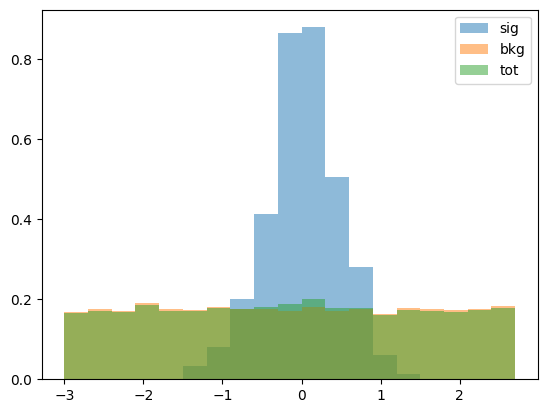

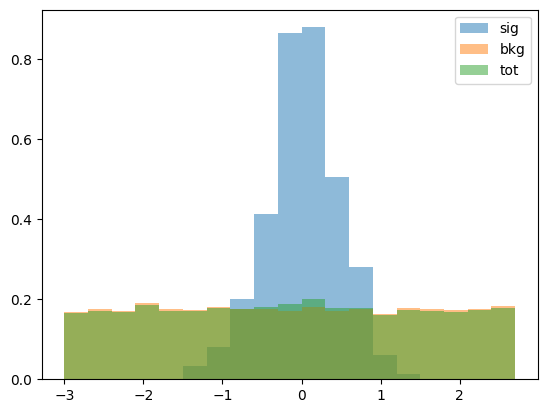

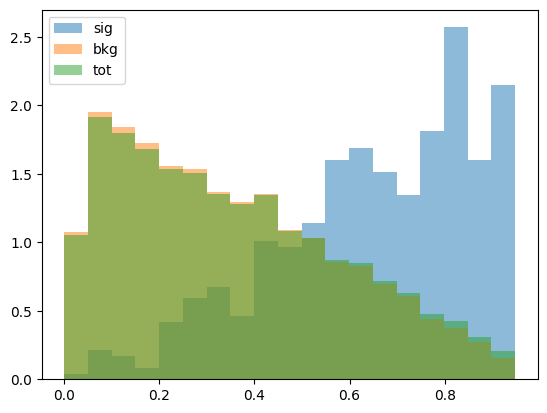

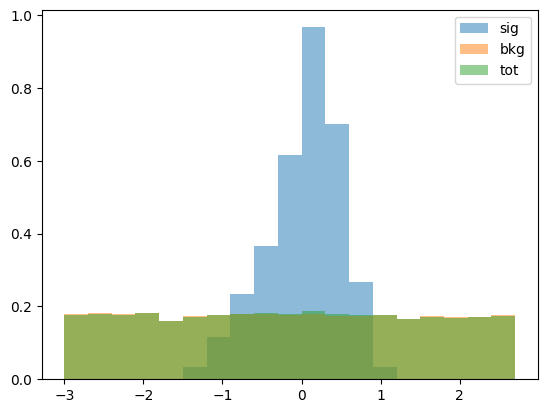

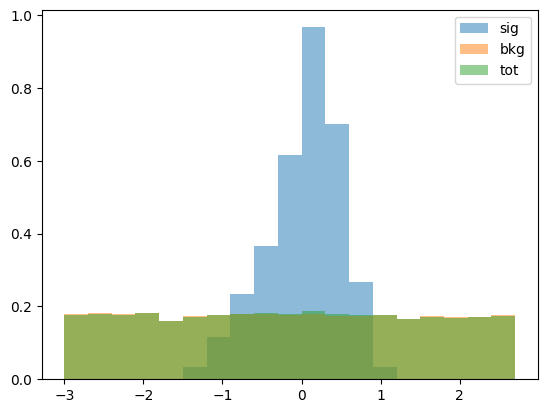

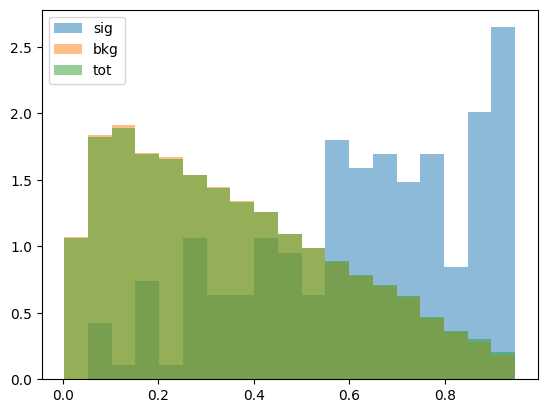

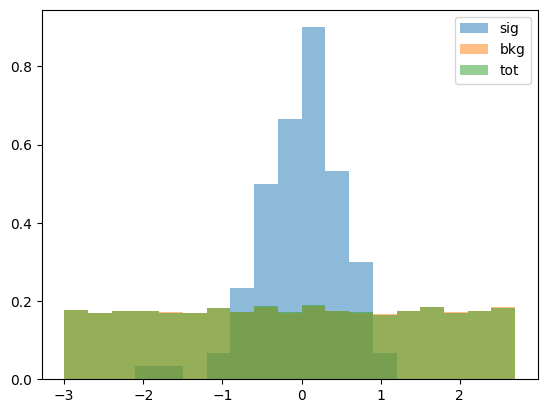

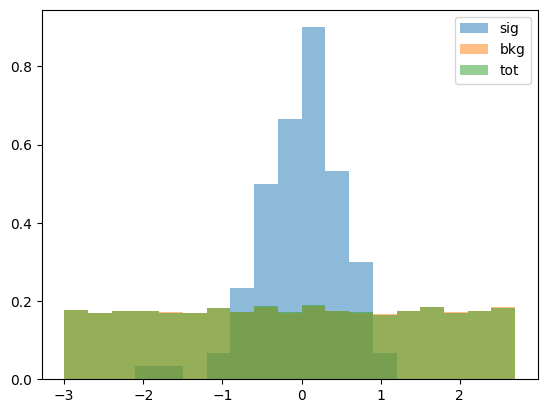

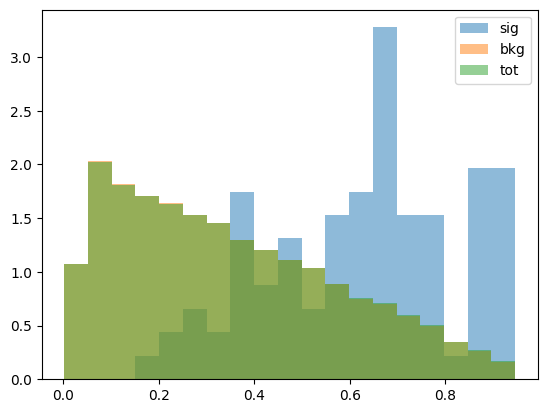

In [70]:
n=20000
dataset25b1,sig25b1,bkg25b1=setupData(1,int(n*0.025),int(n*0.975),1)
dataset10b1,sig10b1,bkg10b1=setupData(1,int(n*0.010),int(n*0.990),1)
dataset05b1,sig05b1,bkg05b1=setupData(1,int(n*0.005),int(n*0.995),1)

#dataset25b2,sig25b2,bkg25b2=setupData(0,int(n*0.025),int(n*0.975),2)
#dataset10b2,sig10b2,bkg10b2=setupData(0,int(n*0.010),int(n*0.990),2)
#dataset05b2,sig05b2,bkg05b2=setupData(0,int(n*0.005),int(n*0.995),2)

#dataset25b3,sig25b3,bkg25b3=setupData(0,int(n*0.025),int(n*0.975),3)
#dataset10b3,sig10b3,bkg10b3=setupData(0,int(n*0.010),int(n*0.990),3)
#dataset05b3,sig05b3,bkg05b3=setupData(0,int(n*0.005),int(n*0.995),3)

In [225]:
%load_ext autoreload
%autoreload 2
from splitfitter import simple_MLPFit_lmfit,fitGausLin,fitGausPowLaw,fitGausFlat
#import splitfitter
#import importlib
#importlib.reload(simple_MLPFit_lmfit)
#simple_MLPFit_lmfit.reload()

rw_model = simple_MLPFit_lmfit(dataset10b1,2,out_channels=1,act_out=False,n_epochs=101,fit_opt=2,bkg_loss=0.1,iFitFunc=fitGausFlat(iNFreePars=3))
rw_model.training_mse()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch: 0 LOSS train: -3.534360408782959 Pars 23.24518839170991 - 27.542918560871254
Epoch: 10 LOSS train: -0.45764684677124023 Pars 19.231299818339547 - 20.69587115265589
Epoch: 20 LOSS train: -8.590232849121094 Pars 18.601346721273117 - 27.381587647525453
Epoch: 30 LOSS train: -33.8531379699707 Pars 21.35308915585143 - 55.20628545364818
Epoch: 40 LOSS train: -40.833290100097656 Pars 18.832778732901858 - 59.6691730144199
Epoch: 50 LOSS train: -47.126617431640625 Pars 16.211710886608046 - 63.475203805299394
Epoch: 60 LOSS train: -49.11976623535156 Pars 15.280621670490818 - 64.98655144954904
Epoch: 70 LOSS train: -49.79862594604492 Pars 14.22153563887723 - 64.33702205983161
Epoch: 80 LOSS train: -50.971710205078125 Pars 13.542333697218641 - 65.28660258887444
Epoch: 90 LOSS train: -51.3739013671875 Pars 12.896220589090774 - 64.73294249867025
Epoch: 100 LOSS train: -52.226905822753906 Pars 12.3140407161

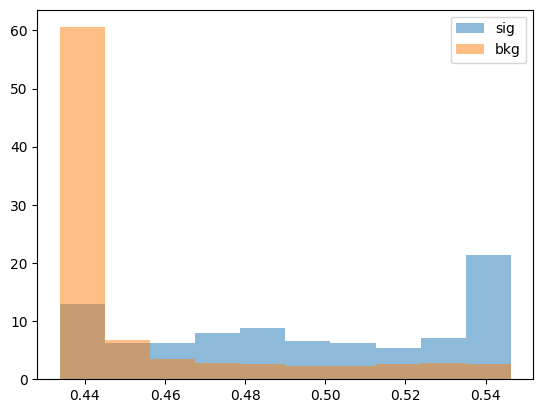

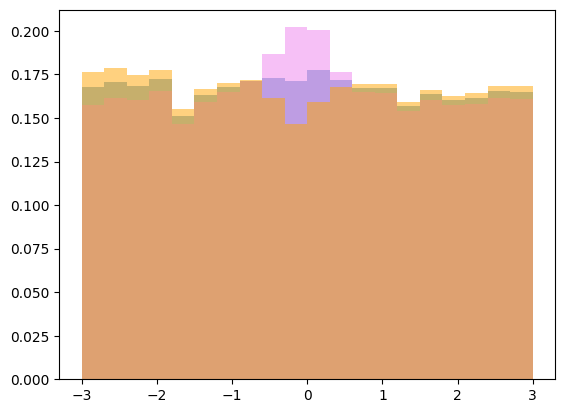

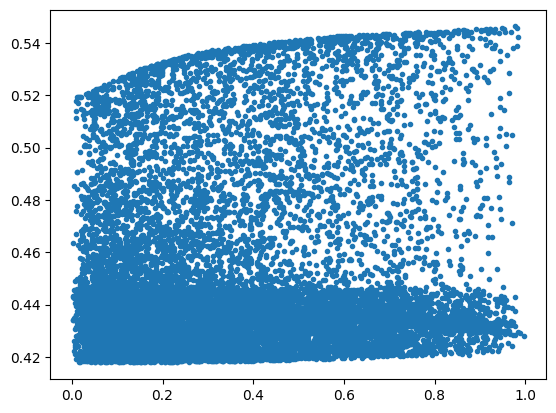

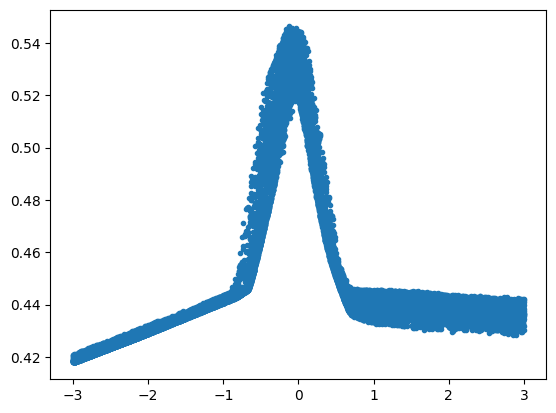

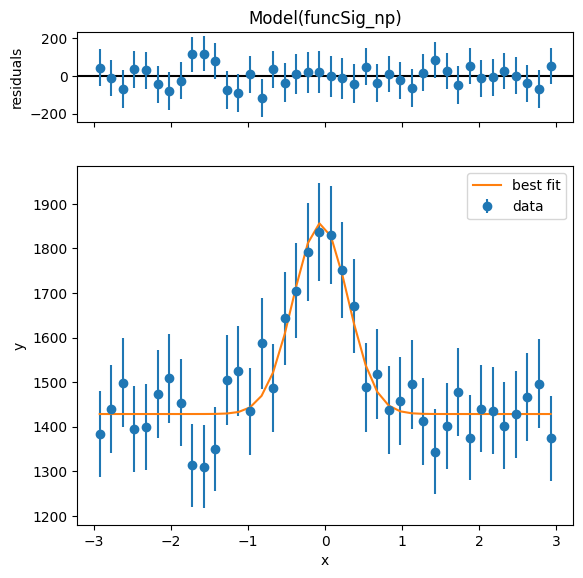

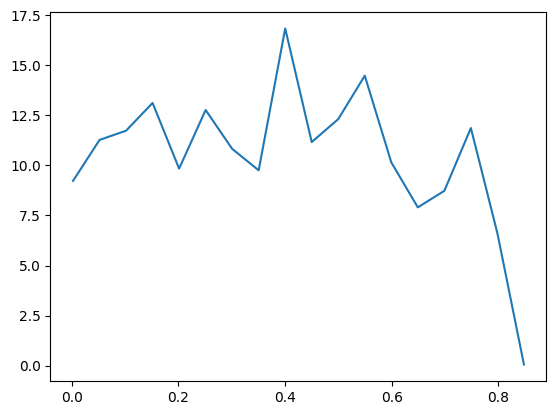

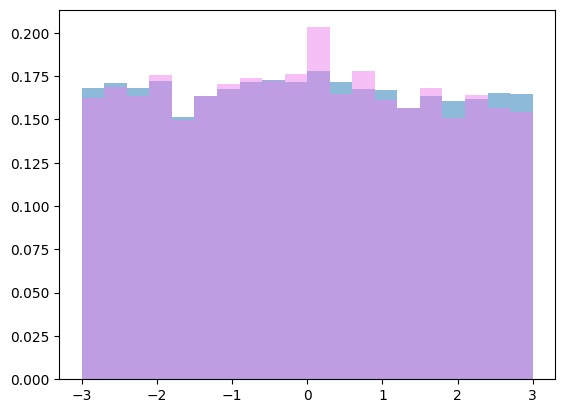

In [226]:
def plotMassSel(iDisc,iDataIn):
    bins=plt.hist(iDataIn,bins=20,density=True,alpha=0.5)
    plt.hist(iDataIn,bins=bins[1],density=True,alpha=0.5,weights=torch.sigmoid(iDisc[:,0]),color='violet')
    plt.hist(iDataIn,bins=bins[1],density=True,alpha=0.5,weights=1-torch.sigmoid(iDisc[:,0]),color='orange')
    plt.show()

def optimizeSig(iModel,iDisc,iInput):
    sigs=[]
    xmax=torch.max(iDisc[:,1])
    xmin=torch.min(iDisc[:,1])
    nbins=20
    cutrange=torch.arange(xmin,xmax,(xmax-xmin)/nbins)
    pMax=-1
    for pCut in cutrange[0:nbins-2]:
        pMask = iDisc[:,1] > pCut
        pMask = torch.where(pMask, 1.0, 0.0)
        sig=iModel.forward_sig(pMask,iInput)
        if sig > pMax:
            pMax = sig
            optw=pMask
        sigs.append(sig)
    plt.plot(cutrange[0:nbins-2],sigs)
    plt.show()
    
    plt.hist(iInput,bins=20,density=True,alpha=0.5)
    plt.hist(iInput,bins=20,density=True,alpha=0.5,weights=optw,color='violet')
    plt.show()
    
def plotPerf(iSig,iBkg, iModel,iOpt=0):
    lN=iSig.shape[1]-1
    output_sig_disc=iModel.forward_disc(iSig[:,1:].reshape(len(iSig),lN))
    output_bkg_disc=iModel.forward_disc(iBkg[:,1:].reshape(len(iBkg),lN))

    xvals=torch.cat((iSig[:,1:],iBkg[:,1:]))
    input=torch.cat((iSig[:,0],iBkg[:,0]))
    output_disc=torch.cat((output_sig_disc,output_bkg_disc))

    _,bins,_=plt.hist(torch.sigmoid(output_sig_disc[:,0].flatten()).detach().numpy(),density=True,alpha=0.5,label='sig')
    plt.hist(torch.sigmoid(output_bkg_disc[:,0].flatten()).detach().numpy(),density=True,alpha=0.5,label='bkg',bins=bins)
    plt.legend()
    plt.show()

    plotMassSel(output_disc.detach(),input.detach())

    output_disc_val=torch.sigmoid(output_disc).detach().numpy()
    plt.plot(xvals[:,-1],output_disc_val,'.')
    plt.show()
    plt.plot(xvals[:,0],output_disc_val,'.')
    plt.show()

    if iOpt == 0: 
        xpars,result,chi2=rw_model.forward_fit(torch.sigmoid(output_disc),input,iModel.fitFunc.fitSig)
        result.plot()
    elif iOpt == 2: 
        xpars,result,chi2=rw_model.forward_fit_diff(torch.sigmoid(output_disc),input,iModel.fitFunc.fitSig)
        result.plot()
    plt.show()

    #xxpars,xchi2,xresult=rw_model.forward_fit_diff(torch.sigmoid(output_disc),input,rw_model.model_fit2.fit)
    #print(xchi2,xxpars)
    #xresult.plot()
    #plt.show()
    optimizeSig(iModel,xvals,input.detach())

plotPerf(sig10b1,bkg10b1,rw_model)

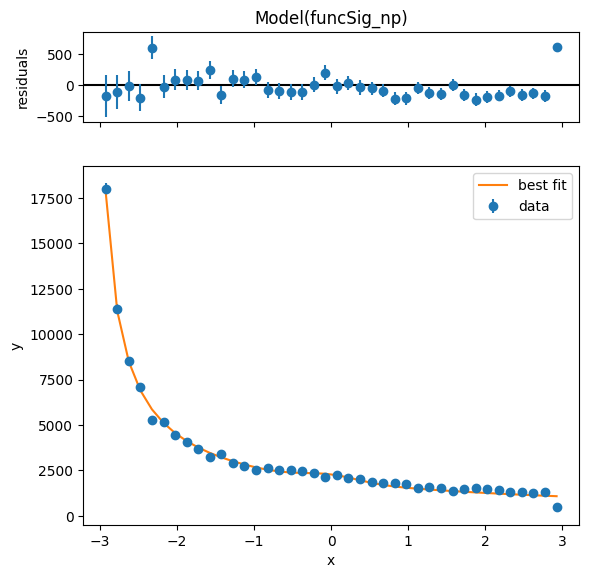

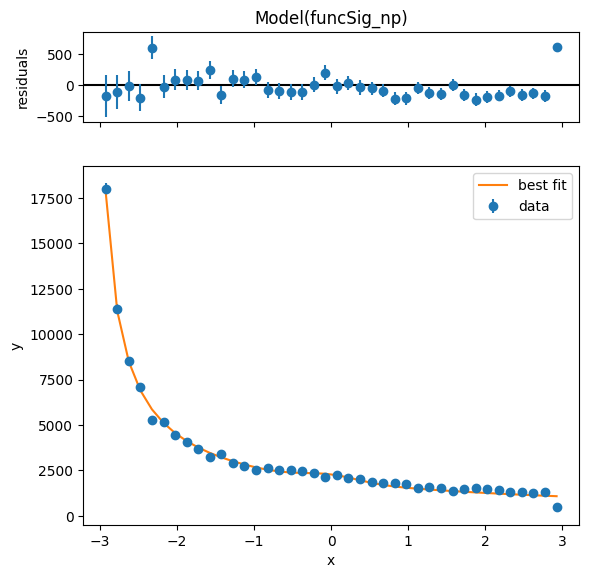

In [9]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader, Subset, SubsetRandomSampler, random_split
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from matplotlib import pyplot as plt
import lmfit
from scipy import interpolate
from scipy import stats
from splitfitter import simple_MLPFit_lmfit,fitGausLin,fitGausPowLaw

nbins=40
xmax=3.0
xmin=-3.0
delta      = (xmax - xmin) / nbins
BIN_Table  = torch.arange(start=0, end=nbins+1, step=1) * delta +xmin
h_r        = 0.5*(BIN_Table[1:] + BIN_Table[:-1])
input=torch.cat((sig10b3[:,0],bkg10b3[:,0]))
tmp=fitGausPowLaw()
yhist,xbins=torch.histogram(input,BIN_Table,density=False)
yerr=((torch.sqrt(yhist))/delta).detach().numpy()
ytmp=(yhist*1./delta).detach().numpy()
xtmp=h_r.detach().numpy()
_,result,_=tmp.fitSig(xtmp,ytmp,yerr)
result.plot()